In [284]:
%matplotlib inline
import numpy as np
import pandas as pd
import datetime as dt
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
data = pd.read_csv ('C:/Users/garim/Documents/Projects/Data Mining Project/ted_main.csv')
#print (data.columns)
print (data['film_date'].head())
print (data['published_date'].head())
data['film_date'] =data['film_date'].apply(lambda x: dt.datetime.fromtimestamp( int(x)).strftime('%d-%m-%Y'))
data['published_date'] = data['published_date'].apply(lambda x: dt.datetime.fromtimestamp( int(x)).strftime('%d-%m-%Y'))
print (data['film_date'].head())
print (data['published_date'].head())
#data.head()

0    1140825600
1    1140825600
2    1140739200
3    1140912000
4    1140566400
Name: film_date, dtype: int64
0    1151367060
1    1151367060
2    1151367060
3    1151367060
4    1151440680
Name: published_date, dtype: int64
0    24-02-2006
1    24-02-2006
2    23-02-2006
3    25-02-2006
4    21-02-2006
Name: film_date, dtype: object
0    26-06-2006
1    26-06-2006
2    26-06-2006
3    26-06-2006
4    27-06-2006
Name: published_date, dtype: object


In [285]:
import ast
data['ratings'] = data['ratings'].apply(lambda x: ast.literal_eval(x))

In [286]:
#Add Topic column in the dataset
talk_topic = ""
def topic_function(data_topic):
    data_topic = sorted(data_topic, key=lambda k: k['count'])
    return data_topic[0]['name']
data['Topics']= data['ratings'].apply(topic_function)

In [287]:
pos_or_neg = ""
def pos_neg_function(rating):
    i=rating
    if (i=='Beautiful' or i=='Courageous' or i=='Funny' or i=='Informative' or i=='Ingenious' or i=='Inspiring' or i=='Jaw-dropping' or i=='Persuasive' ):
        pos_or_neg=1
    elif (i=='OK'):
        pos_or_neg=0
    else :
        pos_or_neg=-1
    return pos_or_neg
data["sentiment"] = data['Topics'].apply(pos_neg_function)

In [288]:
#Calculating quartile ranges and means
data = data.sort_values('views')
mid = int(len(data)/2)
k=list(data['views'])
lowerQ = np.median(sorted(k[:mid]))
median = np.median(sorted(k))
upperQ = np.median(sorted(k[mid:]))
iq_range = upperQ-lowerQ
print(lowerQ)
print(median)
print(upperQ)
print(iq_range)

755399.0
1124523.5
1701743.0
946344.0


In [289]:
print(max(data['views']))
def is_outlier(data):
    if data > (median + (1.5* iq_range)) or data < (median - (1.5* iq_range)):
        return True
    else:
        return False
#apply the function to the original df:
data.loc[:, 'outlier'] = data['views'].apply(is_outlier)
#filter to only non-outliers:
data = data[~(data.outlier)]
data.head()
len(data)
print(max(data['views']))

47227110
2543750


In [290]:
data = data.sort_values('views')
mid = int(len(data)/2)
k=list(data['views'])
lowerQ = np.median(sorted(k[:mid]))
mean = np.mean(sorted(k))
upperQ = np.median(sorted(k[mid:]))
iq_range = upperQ-lowerQ
print(lowerQ)
print(mean)
print(upperQ)
print(iq_range)

707788.0
1099370.98648
1428575.0
720787.0


In [291]:
def views_function(data_views):
    if(data_views<=mean):
            return(-1)
    else:
            return(1)
data["views_based"] = data['views'].apply(views_function)
print (data["views_based"].value_counts())
data.columns[data.isnull().any()]

-1    1232
 1     987
Name: views_based, dtype: int64


Index(['speaker_occupation'], dtype='object')

In [292]:
data.to_csv('ted_main_1.csv', sep=',',encoding='utf-8')

In [293]:
#classification for views_based
from sklearn.model_selection import train_test_split
predictors = data.drop(['views','views_based','Topics','published_date','film_date','comments','description','event','main_speaker','name','ratings','related_talks','speaker_occupation','tags','title','url'], axis=1)
target = data["views_based"]
x_train, x_val, y_train, y_val = train_test_split(predictors, target, test_size = 0.22, random_state = 1)

In [294]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

56.44
Confusion matrix
[[ 87 198]
 [ 15 189]]
Precision : 0.488372093023
Recall : 0.926470588235
F measure : 0.639593908629


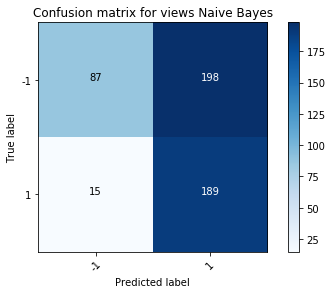

In [295]:
# Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
gaussian = GaussianNB()
gaussian.fit(x_train, y_train)
y_pred = gaussian.predict(x_val)
acc_gaussian = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_gaussian)
cnf_matrix=confusion_matrix(y_val,y_pred)
plot_confusion_matrix(cnf_matrix,classes=['-1','1'],
                      title='Confusion matrix for views Naive Bayes')
plt.figure()
#y_val = label_binarize(y_val, classes=[-1,1])
precision = precision_score(y_val,y_pred)
recall=recall_score(y_val,y_pred)
fscore = f1_score(y_val,y_pred)
print("Precision : " + str(precision))
print("Recall : "+ str(recall))
print("F measure : " + str(fscore))

60.74
Confusion matrix
[[213  72]
 [120  84]]
Precision : 0.538461538462
Recall : 0.411764705882
F measure : 0.466666666667


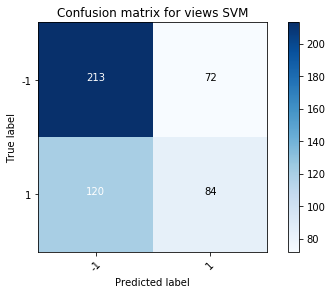

In [296]:
# Support Vector Machines
from sklearn.svm import SVC

svc = SVC()
svc.fit(x_train, y_train)
y_pred = svc.predict(x_val)
acc_svc = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_svc)
cnf_matrix=confusion_matrix(y_val,y_pred)
plot_confusion_matrix(cnf_matrix,classes=['-1','1'],
                      title='Confusion matrix for views SVM')
precision = precision_score(y_val,y_pred)
recall=recall_score(y_val,y_pred)
fscore = f1_score(y_val,y_pred)
print("Precision : " + str(precision))
print("Recall : "+ str(recall))
print("F measure : " + str(fscore))
plt.figure()

62.58
Confusion matrix
[[198  87]
 [ 96 108]]
Precision : 0.553846153846
Recall : 0.529411764706
F measure : 0.541353383459


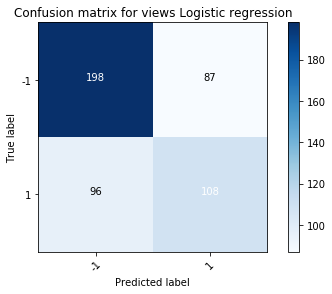

In [297]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(x_train, y_train)
y_pred = logreg.predict(x_val)
acc_logreg = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_logreg)
cnf_matrix=confusion_matrix(y_val,y_pred)
plot_confusion_matrix(cnf_matrix,classes=['-1','1'],
                      title='Confusion matrix for views Logistic regression')
precision = precision_score(y_val,y_pred)
recall=recall_score(y_val,y_pred)
fscore = f1_score(y_val,y_pred)
print("Precision : " + str(precision))
print("Recall : "+ str(recall))
print("F measure : " + str(fscore))
plt.figure()

57.87
Confusion matrix
[[167 118]
 [ 88 116]]
Precision : 0.495726495726
Recall : 0.56862745098
F measure : 0.529680365297


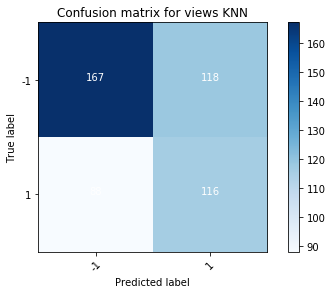

In [298]:
# KNN or k-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
y_pred = knn.predict(x_val)
acc_knn = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_knn)
cnf_matrix=confusion_matrix(y_val,y_pred)
plot_confusion_matrix(cnf_matrix,classes=['-1','1'],
                      title='Confusion matrix for views KNN')
precision = precision_score(y_val,y_pred)
recall=recall_score(y_val,y_pred)
fscore = f1_score(y_val,y_pred)
print("Precision : " + str(precision))
print("Recall : "+ str(recall))
print("F measure : " + str(fscore))
plt.figure()

In [299]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

randomforest = RandomForestClassifier()
randomforest.fit(x_train, y_train)
y_pred = randomforest.predict(x_val)
acc_randomforest = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_randomforest)

59.1


In [300]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression',  'Naive Bayes'],
    'Score': [acc_svc, acc_knn, acc_logreg, acc_gaussian]})
models.sort_values(by='Score', ascending=False)

,Model,Score
2,Logistic Regression,62.58
0,Support Vector Machines,60.74
1,KNN,57.87
3,Naive Bayes,56.44


In [315]:
#classification for comments
from sklearn.model_selection import train_test_split
predictors = data.drop(['sentiment','Topics','published_date','film_date','description','event','main_speaker','name','ratings','related_talks','speaker_occupation','tags','title','url'], axis=1)
target = data["sentiment"]

x_train, x_val, y_train, y_val = train_test_split(predictors, target, test_size = 0.22, random_state = 1)

57.87
Confusion matrix
[[260   2  16]
 [  1   0   0]
 [187   0  23]]
Precision : 0.583201307895
Recall : 0.578732106339
F measure : 0.486530957103


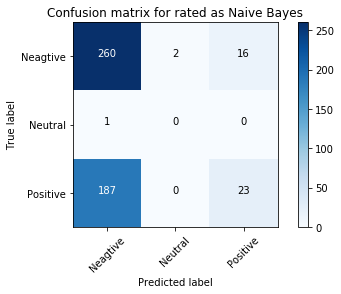

In [326]:
# Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

gaussian = GaussianNB()
gaussian.fit(x_train, y_train)
y_pred = gaussian.predict(x_val)
acc_gaussian = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_gaussian)
cnf_matrix=confusion_matrix(y_val,y_pred)
plot_confusion_matrix(cnf_matrix,classes=["Neagtive","Neutral","Positive"],
                      title='Confusion matrix for rated as Naive Bayes')
#y_val = label_binarize(y_val, classes=[-1,0,1])
precision = precision_score(y_val,y_pred,average='weighted')
recall=recall_score(y_val,y_pred,average='weighted')
fscore = f1_score(y_val,y_pred,average='weighted')
print("Precision : " + str(precision))
print("Recall : "+ str(recall))
print("F measure : " + str(fscore))
plt.figure()

56.85
[[278   0   0]
 [  1   0   0]
 [210   0   0]]
Confusion matrix
[[278   0   0]
 [  1   0   0]
 [210   0   0]]
Precision : 0.323200388088
Recall : 0.568507157464
F measure : 0.412112098501


C:\Users\garim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\garim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


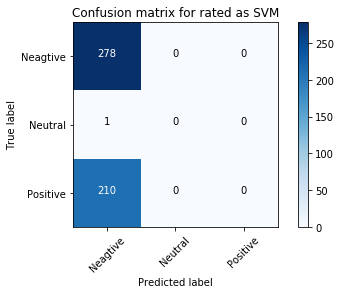

In [336]:
# Support Vector Machines
from sklearn.svm import SVC

svc = SVC()
svc.fit(x_train, y_train)
y_pred = svc.predict(x_val)
acc_svc = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_svc)
cnf_matrix=confusion_matrix(y_val,y_pred)
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix,classes=["Neagtive","Neutral","Positive"],
                      title='Confusion matrix for rated as SVM')
precision = precision_score(y_val,y_pred,average='weighted')
recall=recall_score(y_val,y_pred,average='weighted')
fscore = f1_score(y_val,y_pred,average='weighted')
print("Precision : " + str(precision))
print("Recall : "+ str(recall))
print("F measure : " + str(fscore))
plt.figure()

56.24
Confusion matrix
[[268   0  10]
 [  1   0   0]
 [203   0   7]]
Precision : 0.499627905649
Recall : 0.562372188139
F measure : 0.432778885856


C:\Users\garim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\garim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


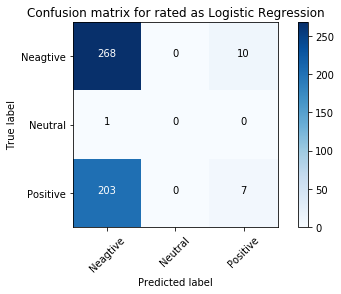

In [337]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(x_train, y_train)
y_pred = logreg.predict(x_val)
acc_logreg = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_logreg)
cnf_matrix=confusion_matrix(y_val,y_pred)
plot_confusion_matrix(cnf_matrix,classes=["Neagtive","Neutral","Positive"],
                      title='Confusion matrix for rated as Logistic Regression')
precision = precision_score(y_val,y_pred,average='weighted')
recall=recall_score(y_val,y_pred,average='weighted')
fscore = f1_score(y_val,y_pred,average='weighted')
print("Precision : " + str(precision))
print("Recall : "+ str(recall))
print("F measure : " + str(fscore))
plt.figure()

55.62
Confusion matrix
[[203   0  75]
 [  1   0   0]
 [141   0  69]]
Precision : 0.54029000326
Recall : 0.556237218814
F measure : 0.537899685287


C:\Users\garim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\garim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


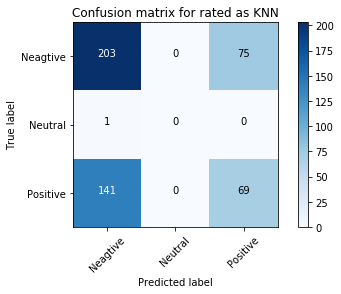

In [338]:
# KNN or k-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
y_pred = knn.predict(x_val)
acc_knn = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_knn)
cnf_matrix=confusion_matrix(y_val,y_pred)
plot_confusion_matrix(cnf_matrix,classes=["Neagtive","Neutral","Positive"],
                      title='Confusion matrix for rated as KNN')
precision = precision_score(y_val,y_pred,average='weighted')
recall=recall_score(y_val,y_pred,average='weighted')
fscore = f1_score(y_val,y_pred,average='weighted')
print("Precision : " + str(precision))
print("Recall : "+ str(recall))
print("F measure : " + str(fscore))
plt.figure()

In [ ]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

randomforest = RandomForestClassifier()
randomforest.fit(x_train, y_train)
y_pred = randomforest.predict(x_val)
acc_randomforest = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_randomforest)

In [ ]:
def visualize_tree(tree, feature_names):
    """Create tree png using graphviz.

    Args
    ----
    tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    """
    with open("dt.dot", 'w') as f:
        export_graphviz(tree, out_file=f,
                        feature_names=feature_names)

    command = ["dot", "-Tpng", "dt.dot", "-o", "dt.png"]
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")


In [ ]:
#Decision Tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

decisiontree = DecisionTreeClassifier()
decisiontree.fit(x_train, y_train)
y_pred = decisiontree.predict(x_val)
acc_decisiontree = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_decisiontree)


In [ ]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression',  'Naive Bayes'],
    'Score': [acc_svc, acc_knn, acc_logreg, acc_gaussian]})
models.sort_values(by='Score', ascending=False)